# Admixture

We want to identify **admixture in the Ace1 locus**, from *coluzzii* to *gambiae* in Western Africa (CIcol, BFcol, BFgam, GHgam, GHcol...).

Using *arabiensis* as outgroup.

## Input

Input files:

In [1]:
# input data
outdir      = "results_admixture/"
metasam_fn  = "metadata/samples.meta_phenotypes_acegenotype.simple.txt"
callset_fn  = "/home/xavi/Documents/VariationAg1k/data/phase2.AR1/variation/main/zarr2/ag1000g.phase2.ar1.pass/"
accessi_fn  = "/home/xavi/Documents/VariationAg1k/data/phase2.AR1/accessibility/accessibility.h5"
haploty_fn  = "/home/xavi/Documents/VariationAg1k/data/phase2.AR1/haplotypes/zarr2/ag1000g.phase2.ar1.samples/"
snpeff_fn   = "/home/xavi/Documents/VariationAg1k/data/phase2.AR1/snpeff/zarr2/"
gffann_fn   = "metadata/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.9.gff3"

# define populations
popl    = ["AOcol_FALSE","BFcol_FALSE","BFcol_TRUE","BFgam_FALSE","BFgam_TRUE","CIcol_FALSE","CIcol_TRUE",
           "CMgam_FALSE","FRgam_FALSE","GAgam_FALSE","GHcol_FALSE","GHcol_TRUE","GHgam_FALSE","GHgam_TRUE",
           "GNcol_FALSE","GNgam_FALSE","GNgam_TRUE","GQgam_FALSE","UGgam_FALSE"]
popc    = "pop_dup"
sub1l   = popl
sub1c   = popc
chrom   = "2R"

outcode     = "admix_arab"
popD        = "arab"
outgroup_fn = "/home/xavi/dades/Variation/phase1.AR3_Fontaine_AltSps/genotypes/arab_ref_ug_vqsr_cnvrt_sort.zarr/"

# exclude these samples
excludec   = "ox_code"
excludel   = list(("NO RES"))

Location of Ace1:

In [2]:
ace_start = 3489213 # start gene
ace_end   = 3493788 # end gene
ace_119S  = 3492074 # resistant variant
ace_dups  = 3436800 # start duplication
ace_dupe  = 3639600 # end duplication

Libraries:

In [3]:
%%capture
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import bcolz
import scipy
from matplotlib.gridspec import GridSpec
from matplotlib.backends.backend_pdf import PdfPages
import zarr
import pandas as pd
import allel
import h5py
import itertools

Functions:

In [4]:
# load plot settings
sns.set(context="notebook",style="ticks",
        font_scale=1.3,rc={"lines.linewidth": 1},
        font="Arial",palette="bright")

# import gff
def geneset_gff(geneset):
    items = []
    for n in geneset.dtype.names:
        v = geneset[n]
        if v.dtype.kind == 'S':
            v = v.astype('U')
        items.append((n, v))
    return pd.DataFrame.from_items(items)

## Load data

### Genotypes, haplotypes, variants & samples

Load data for all variants & genotypes. Population and sample structure:

In [5]:
# load samples list with sample code, groupings, locations etc.
samples_df   = pd.read_csv(metasam_fn, sep='\t')
samples_bool = (
    samples_df[popc].isin(popl).values & 
    samples_df[sub1c].isin(sub1l).values &
    ~samples_df[excludec].isin(excludel).values
)
samples_sub  = samples_df[samples_bool]
samples_sub.reset_index(drop=True, inplace=True)

# indexed dictionary of populations
popdict = dict()
for popi in popl: 
    popdict[popi]  = samples_sub[samples_sub[popc] == popi].index.tolist()

# add an extra population composed of all other locations
popdict["all"] = []
for popi in popl:
    popdict["all"] = popdict["all"] + popdict[popi]
    
# report
print("Data:")
print("* Samples     = ", samples_sub.shape[0])
print("* Populations = ", set(samples_sub[popc]))
print(samples_sub.groupby(("population",popc)).size())


Data:
* Samples     =  938
* Populations =  {'GHcol_FALSE', 'CMgam_FALSE', 'FRgam_FALSE', 'AOcol_FALSE', 'BFgam_FALSE', 'GQgam_FALSE', 'GHgam_FALSE', 'BFcol_TRUE', 'GNgam_FALSE', 'GAgam_FALSE', 'GHcol_TRUE', 'BFgam_TRUE', 'GHgam_TRUE', 'CIcol_TRUE', 'UGgam_FALSE', 'GNgam_TRUE', 'GNcol_FALSE', 'CIcol_FALSE', 'BFcol_FALSE'}
population  pop_dup    
AOcol       AOcol_FALSE     78
BFcol       BFcol_FALSE     72
            BFcol_TRUE       3
BFgam       BFgam_FALSE     63
            BFgam_TRUE      29
CIcol       CIcol_FALSE      9
            CIcol_TRUE      62
CMgam       CMgam_FALSE    297
FRgam       FRgam_FALSE     24
GAgam       GAgam_FALSE     69
GHcol       GHcol_FALSE     49
            GHcol_TRUE       6
GHgam       GHgam_FALSE      2
            GHgam_TRUE      10
GNcol       GNcol_FALSE      4
GNgam       GNgam_FALSE     30
            GNgam_TRUE      10
GQgam       GQgam_FALSE      9
UGgam       UGgam_FALSE    112
dtype: int64


/home/xavi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.


Load variant, genotypes, haplotypes, accessibility, etc. data:

In [6]:
# declare objects with variant data
callset   = zarr.open(callset_fn)
# callset   = h5py.File(callset_fn % chrom,mode="r")
snpeff_zr = zarr.open(snpeff_fn)
    
# GENOTYPES
# variants of genotypes
print("Variants...")
callset_var = callset[chrom]["variants"]
genvars = allel.VariantChunkedTable(callset_var,names=["POS","REF","ALT","num_alleles"],index="POS") # variants

# genotype data
print("Genotypes...")
callset_gen = callset[chrom]["calldata"]["genotype"]
genotyp     = allel.GenotypeChunkedArray(callset_gen) # genotypes
genotyp_sub = genotyp.subset(sel0=None, sel1=samples_bool)

# allele counts in pops. Only data from "all" is used now, so subpops
# can be changed later (if genalco is re-calculated with new popdict)
print("Genotype counts...")
genalco_sep = genotyp_sub.count_alleles_subpops(subpops=popdict)

Variants...
Genotypes...
Genotype counts...


In [7]:
# load arabiensis data
print("Variants arabiensis...")
callset_arab     = zarr.open(outgroup_fn)
callset_arab_var = callset_arab[chrom]["variants"]
genvars_arab     = allel.VariantChunkedTable(callset_arab_var,names=["POS","REF","ALT"],index="POS") # variants
ix_arab_unique   = np.unique(genvars_arab["POS"][:],return_index=True)[1]
genvars_arab_u   = genvars_arab[:][ix_arab_unique]
print(genvars_arab_u.shape,genvars_arab.shape)

print("Genotypes arabiensis...")
callset_arab_gen = callset_arab[chrom]["calldata"]["GT"]
genotyp_arab     = allel.GenotypeChunkedArray(callset_arab_gen) # genotypes
genotyp_arab_u   = genotyp_arab[:][ix_arab_unique]
print(genotyp_arab_u.shape,genotyp_arab.shape)

print("Genotype counts arabiensis...")
aradict          = { popD : list(range(genotyp_arab_u.shape[1])) }
genalco_arab_u   = genotyp_arab_u.count_alleles_subpops(subpops=aradict)
print(genalco_arab_u[popD].shape)

Variants arabiensis...
(48414272,) (48451161,)
Genotypes arabiensis...
(48414272, 12, 2) (48451161, 12, 2)
Genotype counts arabiensis...
(48414272, 2)


In [8]:
# subset data: segregating alleles, biallelic and no singletons, and those in outgroup D
print("Subset...")
is_seg      = genalco_sep["all"].is_segregating()[:] # segregating
is_nosing   = genalco_sep["all"][:,:2].min(axis=1)>2 # no singletons
is_bia      = genvars["num_alleles"] == 2            # biallelic "==2" | multiallelic ">1"
is_arab     = np.isin(genvars["POS"][:],test_elements=genvars_arab_u["POS"][:])
genotyp_seg = genotyp_sub.compress((is_seg[:] & is_nosing[:] & is_bia[:] & is_arab[:]))
genvars_seg = genvars.compress((is_seg[:] & is_nosing[:] & is_bia[:] & is_arab[:]))
genalco_seg = genalco_sep.compress((is_seg[:] & is_nosing[:] & is_bia[:] & is_arab[:]))

# report
print("chr %s:\tVariants retained:\t%i out of %i (%.2f%%)" % (
    chrom,genotyp_seg.shape[0],genotyp_sub.shape[0],genotyp_seg.shape[0]/genotyp_sub.shape[0]*100))

Subset...
chr 2R:	Variants retained:	5998789 out of 15425222 (38.89%)


In [9]:
# subset arabiensis to fit phase2
print("Subset arabiensis...")
is_phase2          = np.isin(genvars_arab_u["POS"][:],test_elements=genvars_seg["POS"][:])
genotyp_arab_u_seg = genotyp_arab_u.compress((is_phase2[:]))
genvars_arab_u_seg = genvars_arab_u.compress((is_phase2[:]))
genalco_arab_u_seg = genalco_arab_u[popD].compress((is_phase2[:]))

# report
print("chr %s:\tVariants retained:\t%i out of %i (%.2f%%)" % (
    chrom,genotyp_arab_u_seg.shape[0],genotyp_arab_u.shape[0],genotyp_arab_u_seg.shape[0]/genotyp_arab_u.shape[0]*100))

Subset arabiensis...
chr 2R:	Variants retained:	5998789 out of 48414272 (12.39%)


In [10]:
accessi_df  = h5py.File(accessi_fn,mode="r")
accessi_arr = accessi_df[chrom]["is_accessible"][:]    

Import GFF geneset:

In [11]:
geneset = allel.FeatureTable.from_gff3(gffann_fn,attributes=['ID', 'Parent'])
geneset = geneset_gff(geneset)

/home/xavi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


## Admixture estimation

### Patterson $D$

$D$ statistic or $ABBA-BABA$ test for introgression between CIcol and gambiae populations around it.

* C is pop of interest
* A and B are two pops of the same species (do they have to be isolated?) and we want to see if there was introgression between C and either A or B
* D is most distant outgroup (arabiensis)

```
A   B   C   D
|   |   |   |
^---^   |   |
  |     |   |
  ^-----^   |
     |      |
     ^------^
         | 
```

Interpretation:

* If **`D~0`**, tree concordance
* If **`D>0`**, flow between **A and C**
* If **`D<0`**, flow between **B and C**

In [12]:
# variants in duplicated region
print(samples_sub.groupby((popc)).size())

pop_dup
AOcol_FALSE     78
BFcol_FALSE     72
BFcol_TRUE       3
BFgam_FALSE     63
BFgam_TRUE      29
CIcol_FALSE      9
CIcol_TRUE      62
CMgam_FALSE    297
FRgam_FALSE     24
GAgam_FALSE     69
GHcol_FALSE     49
GHcol_TRUE       6
GHgam_FALSE      2
GHgam_TRUE      10
GNcol_FALSE      4
GNgam_FALSE     30
GNgam_TRUE      10
GQgam_FALSE      9
UGgam_FALSE    112
dtype: int64


I want to identify **admixture in the Ace1 locus**, from coluzzii to gambiae in Western Africa (CIcol, BFcol, BFgam, GHgam, GHcol...). Other populations should have nothing.

In [13]:
# window lengths for SNP blocks
block_len_snp = 5000
step_frac_snp = 0.2
step_perc_snp = int(step_frac_snp * 100)
step_len_snp  = int(block_len_snp * step_frac_snp)

(((CIcol_TRUE,AOcol_FALSE),GHgam_TRUE),arab) dup
(((CIcol_TRUE,AOcol_FALSE),BFgam_TRUE),arab) dup
(((CIcol_TRUE,AOcol_FALSE),GNgam_TRUE),arab) dup
(((CIcol_TRUE,AOcol_FALSE),GHgam_FALSE),arab) dup
(((CIcol_TRUE,AOcol_FALSE),BFgam_FALSE),arab) dup
(((CIcol_TRUE,AOcol_FALSE),GNgam_FALSE),arab) dup
(((CIcol_TRUE,AOcol_FALSE),GAgam_FALSE),arab) dup
(((CIcol_TRUE,AOcol_FALSE),CMgam_FALSE),arab) dup
(((CIcol_FALSE,AOcol_FALSE),GHgam_TRUE),arab) dup
(((CIcol_FALSE,AOcol_FALSE),BFgam_TRUE),arab) dup
(((CIcol_FALSE,AOcol_FALSE),GNgam_TRUE),arab) dup
(((CIcol_FALSE,AOcol_FALSE),GHgam_FALSE),arab) dup
(((CIcol_FALSE,AOcol_FALSE),BFgam_FALSE),arab) dup
(((CIcol_FALSE,AOcol_FALSE),GNgam_FALSE),arab) dup
(((CIcol_FALSE,AOcol_FALSE),GAgam_FALSE),arab) dup
(((CIcol_FALSE,AOcol_FALSE),CMgam_FALSE),arab) dup
(((GHcol_TRUE,AOcol_FALSE),GHgam_TRUE),arab) dup
(((GHcol_TRUE,AOcol_FALSE),BFgam_TRUE),arab) dup
(((GHcol_TRUE,AOcol_FALSE),GNgam_TRUE),arab) dup
(((GHcol_TRUE,AOcol_FALSE),GHgam_FALSE),arab) dup
(

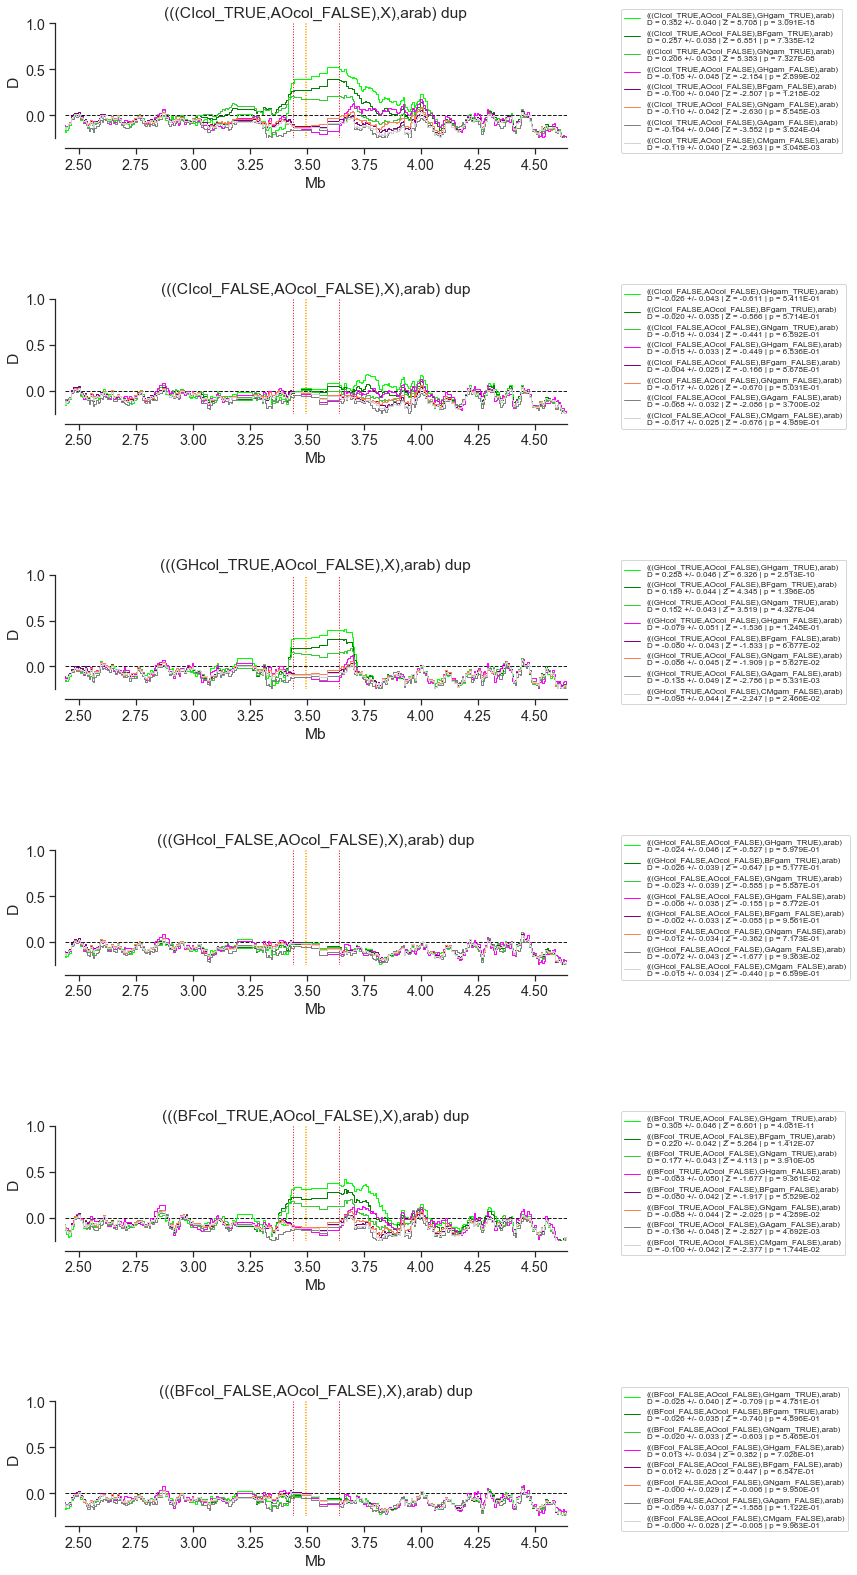

In [14]:
# window positions
windows_pos = allel.moving_statistic(
    genvars_seg["POS"][:],
    statistic=lambda v: v[0],
    size=block_len_snp,step=step_len_snp)

# calculate pvalues and focus in this region: duplicated region proper
var_is_in_dup_bool = np.logical_and(genvars_seg["POS"][:] > ace_dups,genvars_seg["POS"][:] < ace_dupe) # duplicated region

# define population lists to compare
popA_list = ["CIcol_TRUE","CIcol_FALSE","GHcol_TRUE","GHcol_FALSE","BFcol_TRUE","BFcol_FALSE"] # these are pops A
popB_list = ["AOcol_FALSE"] # these are pops B
popC_list = ["GHgam_TRUE","BFgam_TRUE","GNgam_TRUE","GHgam_FALSE","BFgam_FALSE","GNgam_FALSE","GAgam_FALSE","CMgam_FALSE"] # these are used as pops C
colo_list = ["lime",      "green",     "limegreen", "magenta", "purple",  "coral",   "gray",    "lightgray"]

pdf = PdfPages("%s/%s.Dstat_dupregion.pdf" % (outdir,outcode))


fig = plt.figure(figsize=(9,30))
fin = 1
for an,popA in enumerate(popA_list):
    
    for bn,popB in enumerate(popB_list):
        
        # plot duplicated region
        ax2 = plt.subplot(len(popA_list)*len(popB_list)*2, 1, fin)
        sns.despine(ax=ax2,offset=10)
        ax2.set_title("(((%s,%s),X),%s) dup" % (popA,popB,popD))
        ax2.set_xlim(ace_dups/1e6-1,ace_dupe/1e6+1)
        ax2.set_ylim(-0.25,1)
        ax2.set_xlabel("Mb")
        ax2.set_ylabel("D")
        # add lines
        plt.axhline(0, color='k',linestyle="--",label="")
        plt.axvline(ace_dups/1e6, color='r',linestyle=":",label="")
        plt.axvline(ace_dupe/1e6, color='r',linestyle=":",label="")
        plt.axvline(ace_start/1e6, color='orange',linestyle=":",label="")
        plt.axvline(ace_end/1e6, color='orange',linestyle=":",label="")

        for cn,popC in enumerate(popC_list):
            
            if True:

                print("(((%s,%s),%s),%s) dup" % (popA,popB,popC,popD))
                
                # block-wise patterson D (normalised)
                admix_pd_n_win = allel.moving_patterson_d( 
                    aca=genalco_seg[popA][:,0:2],
                    acb=genalco_seg[popB][:,0:2],
                    acc=genalco_seg[popC][:,0:2],
                    acd=genalco_arab_u_seg[:,0:2],
                    size=block_len_snp,step=step_len_snp)

                # estimated D in duplicated region
                admix_pd_av_indup = allel.average_patterson_d(
                    aca=genalco_seg[popA][:,0:2][var_is_in_dup_bool],
                    acb=genalco_seg[popB][:,0:2][var_is_in_dup_bool],
                    acc=genalco_seg[popC][:,0:2][var_is_in_dup_bool],
                    acd=genalco_arab_u_seg[:,0:2][var_is_in_dup_bool],
                    blen=100)
                
                # convert Z-score (num of SD from 0) to pval (two-sided)
                admix_pd_av_indup_pval = scipy.stats.norm.sf(abs(admix_pd_av_indup[2]))*2 
                
                # plot duplicated region
                plt.step(windows_pos/1e6, admix_pd_n_win, color=colo_list[cn], label="(((%s,%s),%s),%s)\nD = %.3f +/- %.3f | Z = %.3f | p = %.3E" % 
                             (popA,popB,popC,popD,
                              admix_pd_av_indup[0],admix_pd_av_indup[1],admix_pd_av_indup[2],admix_pd_av_indup_pval))
                ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), prop={'size': 8})
                
    fin = fin+2
                
# save pdf
pdf.savefig(fig)
                
pdf.close()

(((CIcol_TRUE,AOcol_FALSE),GHgam_TRUE),arab) chr
(((CIcol_TRUE,AOcol_FALSE),BFgam_TRUE),arab) chr
(((CIcol_TRUE,AOcol_FALSE),GNgam_TRUE),arab) chr
(((CIcol_TRUE,AOcol_FALSE),GHgam_FALSE),arab) chr
(((CIcol_TRUE,AOcol_FALSE),BFgam_FALSE),arab) chr
(((CIcol_TRUE,AOcol_FALSE),GNgam_FALSE),arab) chr
(((CIcol_TRUE,AOcol_FALSE),GAgam_FALSE),arab) chr
(((CIcol_TRUE,AOcol_FALSE),CMgam_FALSE),arab) chr
(((CIcol_FALSE,AOcol_FALSE),GHgam_TRUE),arab) chr
(((CIcol_FALSE,AOcol_FALSE),BFgam_TRUE),arab) chr
(((CIcol_FALSE,AOcol_FALSE),GNgam_TRUE),arab) chr
(((CIcol_FALSE,AOcol_FALSE),GHgam_FALSE),arab) chr
(((CIcol_FALSE,AOcol_FALSE),BFgam_FALSE),arab) chr
(((CIcol_FALSE,AOcol_FALSE),GNgam_FALSE),arab) chr
(((CIcol_FALSE,AOcol_FALSE),GAgam_FALSE),arab) chr
(((CIcol_FALSE,AOcol_FALSE),CMgam_FALSE),arab) chr
(((GHcol_TRUE,AOcol_FALSE),GHgam_TRUE),arab) chr
(((GHcol_TRUE,AOcol_FALSE),BFgam_TRUE),arab) chr
(((GHcol_TRUE,AOcol_FALSE),GNgam_TRUE),arab) chr
(((GHcol_TRUE,AOcol_FALSE),GHgam_FALSE),arab) chr
(

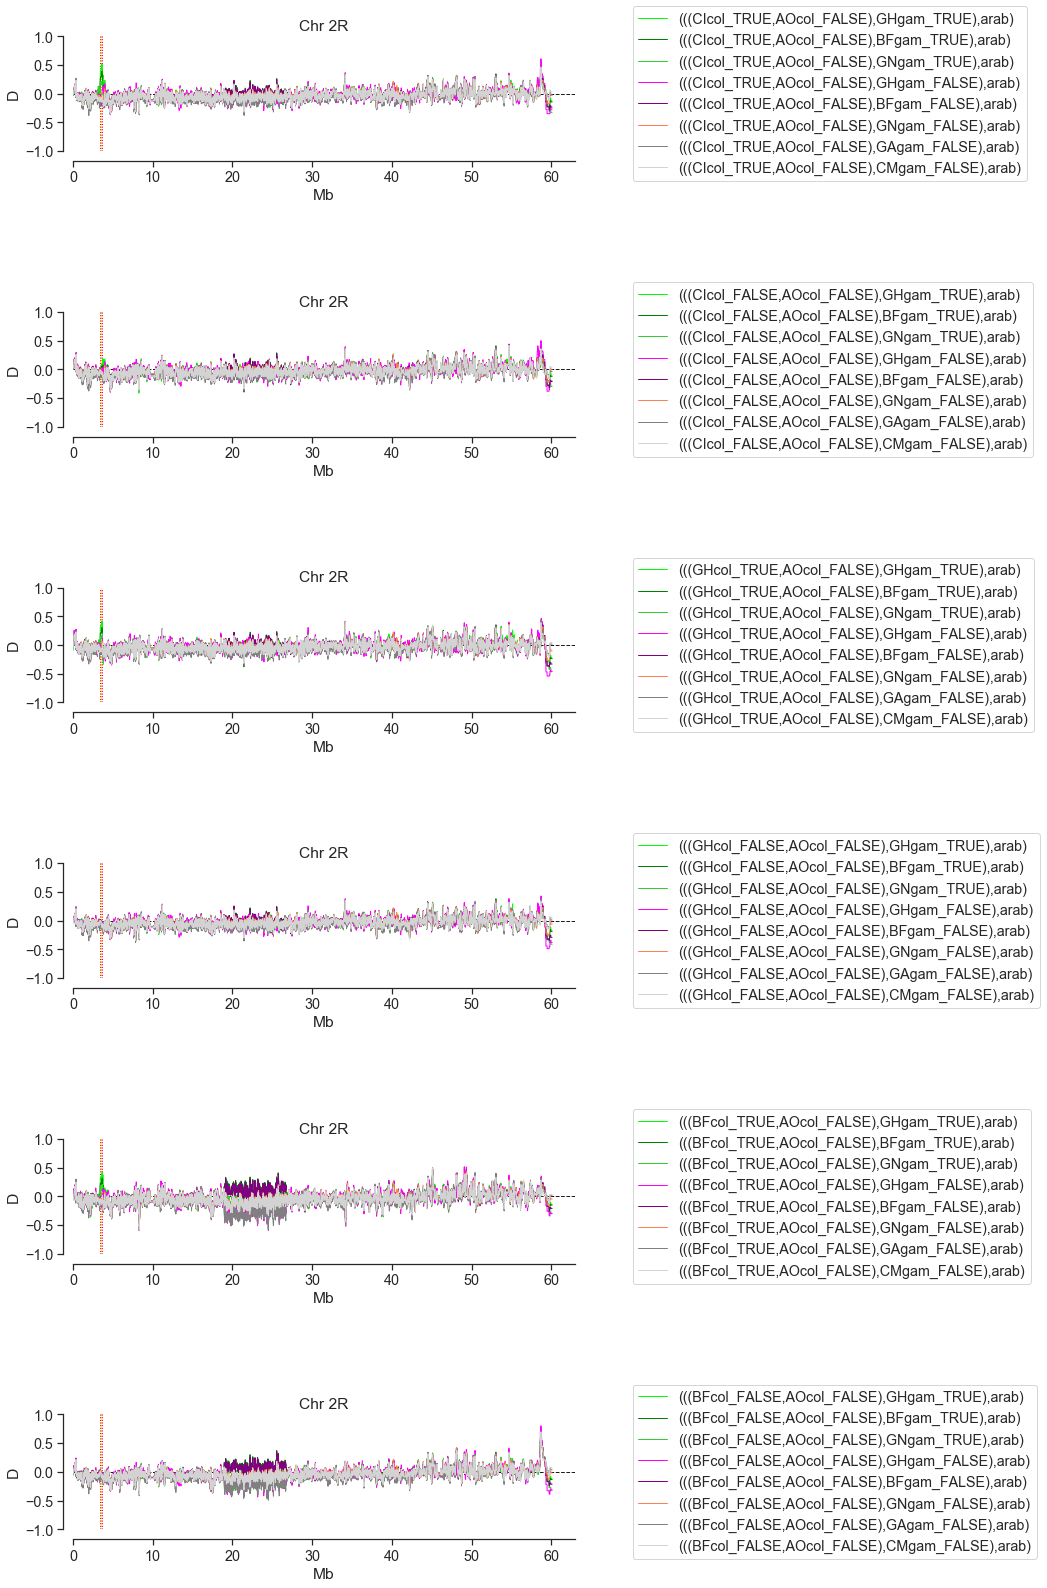

In [15]:
pdf = PdfPages("%s/%s.Dstat_chr.pdf" % (outdir,outcode))

fig = plt.figure(figsize=(9,30))
fin = 1

for an,popA in enumerate(popA_list):
    
    for bn,popB in enumerate(popB_list):
        
        # plot whole chromosome
        ax1 = plt.subplot(len(popA_list)*len(popB_list)*2, 1, fin)
        sns.despine(ax=ax1,offset=10)
        ax1.set_title("Chr %s" % chrom)
        ax1.set_xlim(0,63)
        ax1.set_ylim(-1,1)
        ax1.set_xlabel("Mb")
        ax1.set_ylabel("D")
        # add lines
        plt.axhline(0, color='k',linestyle="--",label="")
        plt.axvline(ace_dups/1e6, color='r',linestyle=":",label="")
        plt.axvline(ace_dupe/1e6, color='r',linestyle=":",label="")
        plt.axvline(ace_start/1e6, color='orange',linestyle=":",label="")
        plt.axvline(ace_end/1e6, color='orange',linestyle=":",label="")
    
        for cn,popC in enumerate(popC_list):
            if True:

                print("(((%s,%s),%s),%s) chr" % (popA,popB,popC,popD))
                
                # block-wise patterson D (normalised)
                admix_pd_n_win = allel.moving_patterson_d( 
                    aca=genalco_seg[popA][:,0:2],
                    acb=genalco_seg[popB][:,0:2],
                    acc=genalco_seg[popC][:,0:2],
                    acd=genalco_arab_u_seg[:,0:2],
                    size=block_len_snp,step=step_len_snp)
                
                # plot whole chromosome
                plt.step(windows_pos/1e6, admix_pd_n_win, color=colo_list[cn], label="(((%s,%s),%s),%s)" % (popA,popB,popC,popD))
                ax1.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

    fin = fin+2
                
# save pdf
pdf.savefig(fig)
                
pdf.close()